In [1]:
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import os
import nltk
import re
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from nltk.tokenize import sent_tokenize
import warnings

%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 8, 4

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# BERT Preprocessing of interviews

In [2]:
name_prefix = 'interview_transcripts_by_turkers'
dataset_csv_name = name_prefix + '.csv'
# data_path = os.path.join(root_path, dataset_csv_name)

df = pd.read_csv(dataset_csv_name, header=None)
df.head()

,0,1
0,p1,Interviewer: So how are you doing?|Interviewee...
1,p10,Interviewer: So how you doing?|Interviewee: G...
2,p11,Interviewer: So tell me about yourself. |Inte...
3,p12,Interviewer: So how are you doing today?|Inter...
4,p13,Interviewer: How are you doing today?|Intervie...


In [3]:
def remove_interview_indicators(string):
    out = re.sub("Interviewer:[a-zA-Z0-9\.\?\!\ \']*\|", "", string) # remove interviewer from the text
    out = re.sub("Interviewer:[a-zA-Z0-9\.\?\!\ \']*", "", out) # remove last interviewer statement from text
    out = re.sub("Interviewee:|\|Interviewee:", "", out) # remove Interviewee indicator from text
    out = re.sub("\|", "", out) # remove remaining |
    out = re.sub("\ \ ", " ", out) # remove double white spaces (still some in there)
    out = re.sub("’|'", "", out) # remove so Im and I'm becomes the same word
    out = re.sub("\[\?\?\?\]", "", out)
    return out

In [4]:
transformed_interviews = df.copy()
transformed_interviews[1] = transformed_interviews[1].transform(remove_interview_indicators)
transformed_interviews.head()

,0,1
0,p1,Im pretty good. ok uhm so have you looked at ...
1,p10,Great how about you? Im a little by the resu...
2,p11,Uhh Im a junior at MIT uhh Im double majoring...
3,p12,Im good how are you? Ok so Im a Junior at MIT...
4,p13,Good. Ok umm Im currently a junior at M.I.T. ...


## Test the BERT tokenizer

In [5]:
# Bert tokenizer

PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [6]:
interviews_BERT = df.copy()
interviews_BERT[1] = interviews_BERT[1].transform(remove_interview_indicators)

interviews_BERT.rename(columns = {0:'Participant', 1:'text_remove_interview_signs'}, inplace = True)
interviews_BERT.head()

,Participant,text_remove_interview_signs
0,p1,Im pretty good. ok uhm so have you looked at ...
1,p10,Great how about you? Im a little by the resu...
2,p11,Uhh Im a junior at MIT uhh Im double majoring...
3,p12,Im good how are you? Ok so Im a Junior at MIT...
4,p13,Good. Ok umm Im currently a junior at M.I.T. ...


In [7]:
interviews_BERT['tokenize_sentence_level'] = interviews_BERT['text_remove_interview_signs'].apply(sent_tokenize)
interviews_BERT['tokenize_sentence_level'].head()

0    [ Im pretty good., ok uhm so have you looked a...
1    [ Great how about you?, Im a little  by the re...
2    [ Uhh Im a junior at MIT uhh Im double majorin...
3    [ Im good how are you?, Ok so Im a Junior at M...
4    [ Good., Ok umm Im currently a junior at M.I.T...
Name: tokenize_sentence_level, dtype: object

In [8]:
interviews_BERT['tokenize'] = interviews_BERT['tokenize_sentence_level'] \
.apply(lambda sentences: [tokenizer.tokenize(sentence) for sentence in sentences])

interviews_BERT['token_ids'] = interviews_BERT['tokenize'] \
.apply(lambda sentences: [tokenizer.convert_tokens_to_ids(sentence) for sentence in sentences])

interviews_BERT.head()

,Participant,text_remove_interview_signs,tokenize_sentence_level,tokenize,token_ids
0,p1,Im pretty good. ok uhm so have you looked at ...,"[ Im pretty good., ok uhm so have you looked a...","[[I, ##m, pretty, good, .], [ok, uh, ##m, so, ...","[[146, 1306, 2785, 1363, 119], [21534, 14863, ..."
1,p10,Great how about you? Im a little by the resu...,"[ Great how about you?, Im a little by the re...","[[Great, how, about, you, ?], [I, ##m, a, litt...","[[2038, 1293, 1164, 1128, 136], [146, 1306, 17..."
2,p11,Uhh Im a junior at MIT uhh Im double majoring...,[ Uhh Im a junior at MIT uhh Im double majorin...,"[[Uh, ##h, I, ##m, a, junior, at, MIT, uh, ##h...","[[11205, 1324, 146, 1306, 170, 4635, 1120, 132..."
3,p12,Im good how are you? Ok so Im a Junior at MIT...,"[ Im good how are you?, Ok so Im a Junior at M...","[[I, ##m, good, how, are, you, ?], [Ok, so, I,...","[[146, 1306, 1363, 1293, 1132, 1128, 136], [23..."
4,p13,Good. Ok umm Im currently a junior at M.I.T. ...,"[ Good., Ok umm Im currently a junior at M.I.T...","[[Good, .], [Ok, um, ##m, I, ##m, currently, a...","[[2750, 119], [23330, 15276, 1306, 146, 1306, ..."


The Bert tokenizer seems to successfully tokenize each sentence.
Some findings:
- Im is split to I, ##m
- Punctation are detected by Bert and will probably be usefull for the model

## Length of the sentences in each interview

To run Bert it is important to know how long each sentence is and what the overall distribution is. The maximum length is 512 tokens but it is advisable to use less as the training will otherwise be very slow

In [9]:
token_lens = []

for interview in interviews_BERT['tokenize']:
    for sentence in interview:
        tokens = tokenizer.encode(sentence, max_length=512, truncation=True)
        token_lens.append(len(tokens))

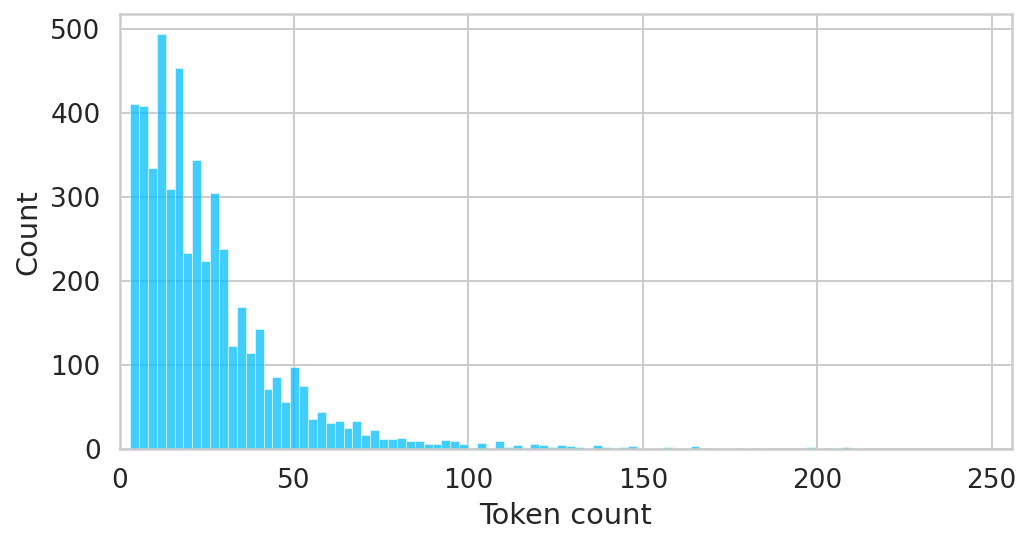

In [10]:
sns.histplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count');

The whole transcripts of each interview are too long for a traditional BERT usage. Sentence level token count can be observed above. From the plot 75-80 tokens seems a reasonable cut of value. 

In [11]:
MAX_LEN = 75

## Labels

In [12]:
name_prefix = 'turker_scores_full_interview'
dataset_csv_name = name_prefix + '.csv'
# data_path = os.path.join(root_path, dataset_csv_name)

interview_scores = pd.read_csv(dataset_csv_name)

index_names = interview_scores[interview_scores['Worker'] != 'AGGR' ].index
interview_scores.drop(index_names, inplace = True)

interview_scores.head()

,Participant,Worker,Overall,RecommendHiring,Colleague,Engaged,Excited,EyeContact,Smiled,SpeakingRate,...,Friendly,Paused,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,Total
9,p1,AGGR,5.297316,5.106224,5.333004,5.541380,5.043890,5.866119,3.576160,4.865590,...,5.254784,5.800468,5.147909,4.891580,5.351075,5.350760,5.845226,5.610513,5.477534,93.131196
19,p3,AGGR,4.414892,4.433070,5.010430,5.616076,5.601586,5.426861,6.062173,5.016286,...,6.500329,4.791550,5.621231,3.912199,4.476537,5.521215,5.549829,6.014960,4.923550,92.225232
29,p4,AGGR,4.494494,4.530129,4.500707,5.494494,4.261343,3.857848,4.852150,4.738000,...,5.369884,5.177447,4.392736,4.688379,5.065190,5.566084,5.324136,5.658364,4.452909,85.535740
39,p5,AGGR,5.457670,5.571558,5.772488,5.903057,4.707062,6.694276,3.920479,4.927181,...,5.649119,5.886326,4.695523,5.582514,6.130488,5.916373,6.322086,6.020070,5.629838,100.667850
49,p6,AGGR,5.106512,4.831482,4.860595,5.020385,4.648259,4.331805,4.194227,4.174891,...,4.495375,5.027823,4.261988,4.826245,5.828977,5.824390,5.619420,5.371858,5.295977,87.640538


### Distribution of class labels

<AxesSubplot:xlabel='Friendly', ylabel='Count'>

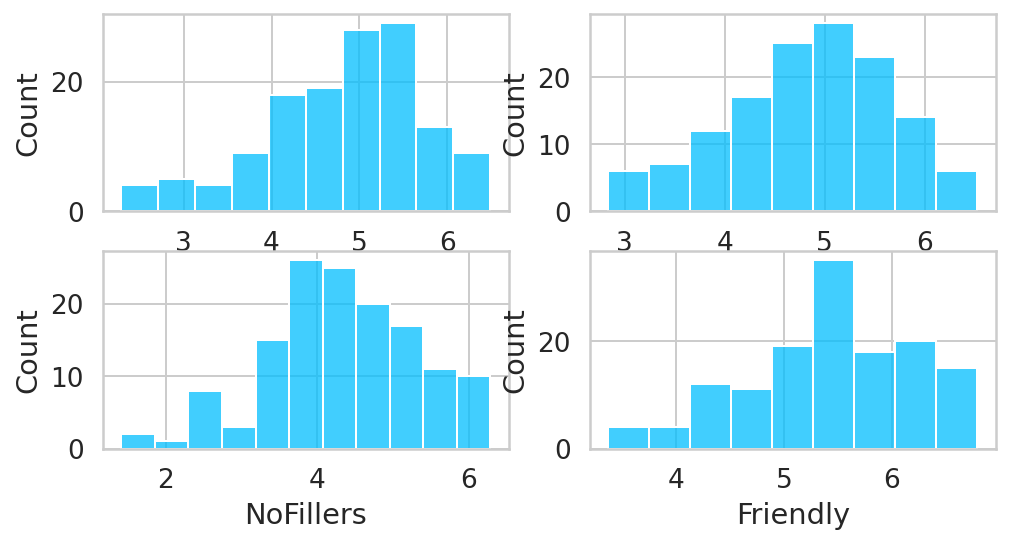

In [13]:
fig, ax =plt.subplots(2,2)
sns.histplot(interview_scores['EngagingTone'], ax=ax[0, 0])
sns.histplot(interview_scores['Excited'], ax=ax[0, 1])
sns.histplot(interview_scores['NoFillers'], ax=ax[1, 0])
sns.histplot(interview_scores['Friendly'], ax=ax[1, 1])

In [14]:
interview_scores[['EngagingTone', 'Excited', 'NoFillers', 'Friendly', 'StructuredAnswers', \
               'Calm', 'NotStressed', 'Focused', 'Authentic', 'NotAwkward']]

,EngagingTone,Excited,NoFillers,Friendly,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward
9,5.147909,5.043890,3.771665,5.254784,4.891580,5.351075,5.350760,5.845226,5.610513,5.477534
19,5.621231,5.601586,3.332458,6.500329,3.912199,4.476537,5.521215,5.549829,6.014960,4.923550
29,4.392736,4.261343,3.111445,5.369884,4.688379,5.065190,5.566084,5.324136,5.658364,4.452909
39,4.695523,4.707062,5.881741,5.649119,5.582514,6.130488,5.916373,6.322086,6.020070,5.629838
49,4.261988,4.648259,3.920329,4.495375,4.826245,5.828977,5.824390,5.619420,5.371858,5.295977
...,...,...,...,...,...,...,...,...,...,...
1338,5.801601,5.806617,4.838943,6.549279,4.878478,5.492810,5.391449,6.083629,6.559118,5.840547
1348,5.625489,5.307262,5.047772,6.529525,4.890114,5.112062,5.750670,5.988186,6.248887,5.169949
1358,5.239474,5.584830,4.097177,5.970750,4.918227,4.985095,4.998952,6.554104,6.372852,4.800594
1368,5.208898,5.137644,4.126127,5.022182,4.240302,5.648693,5.939815,5.078459,6.008339,5.154665


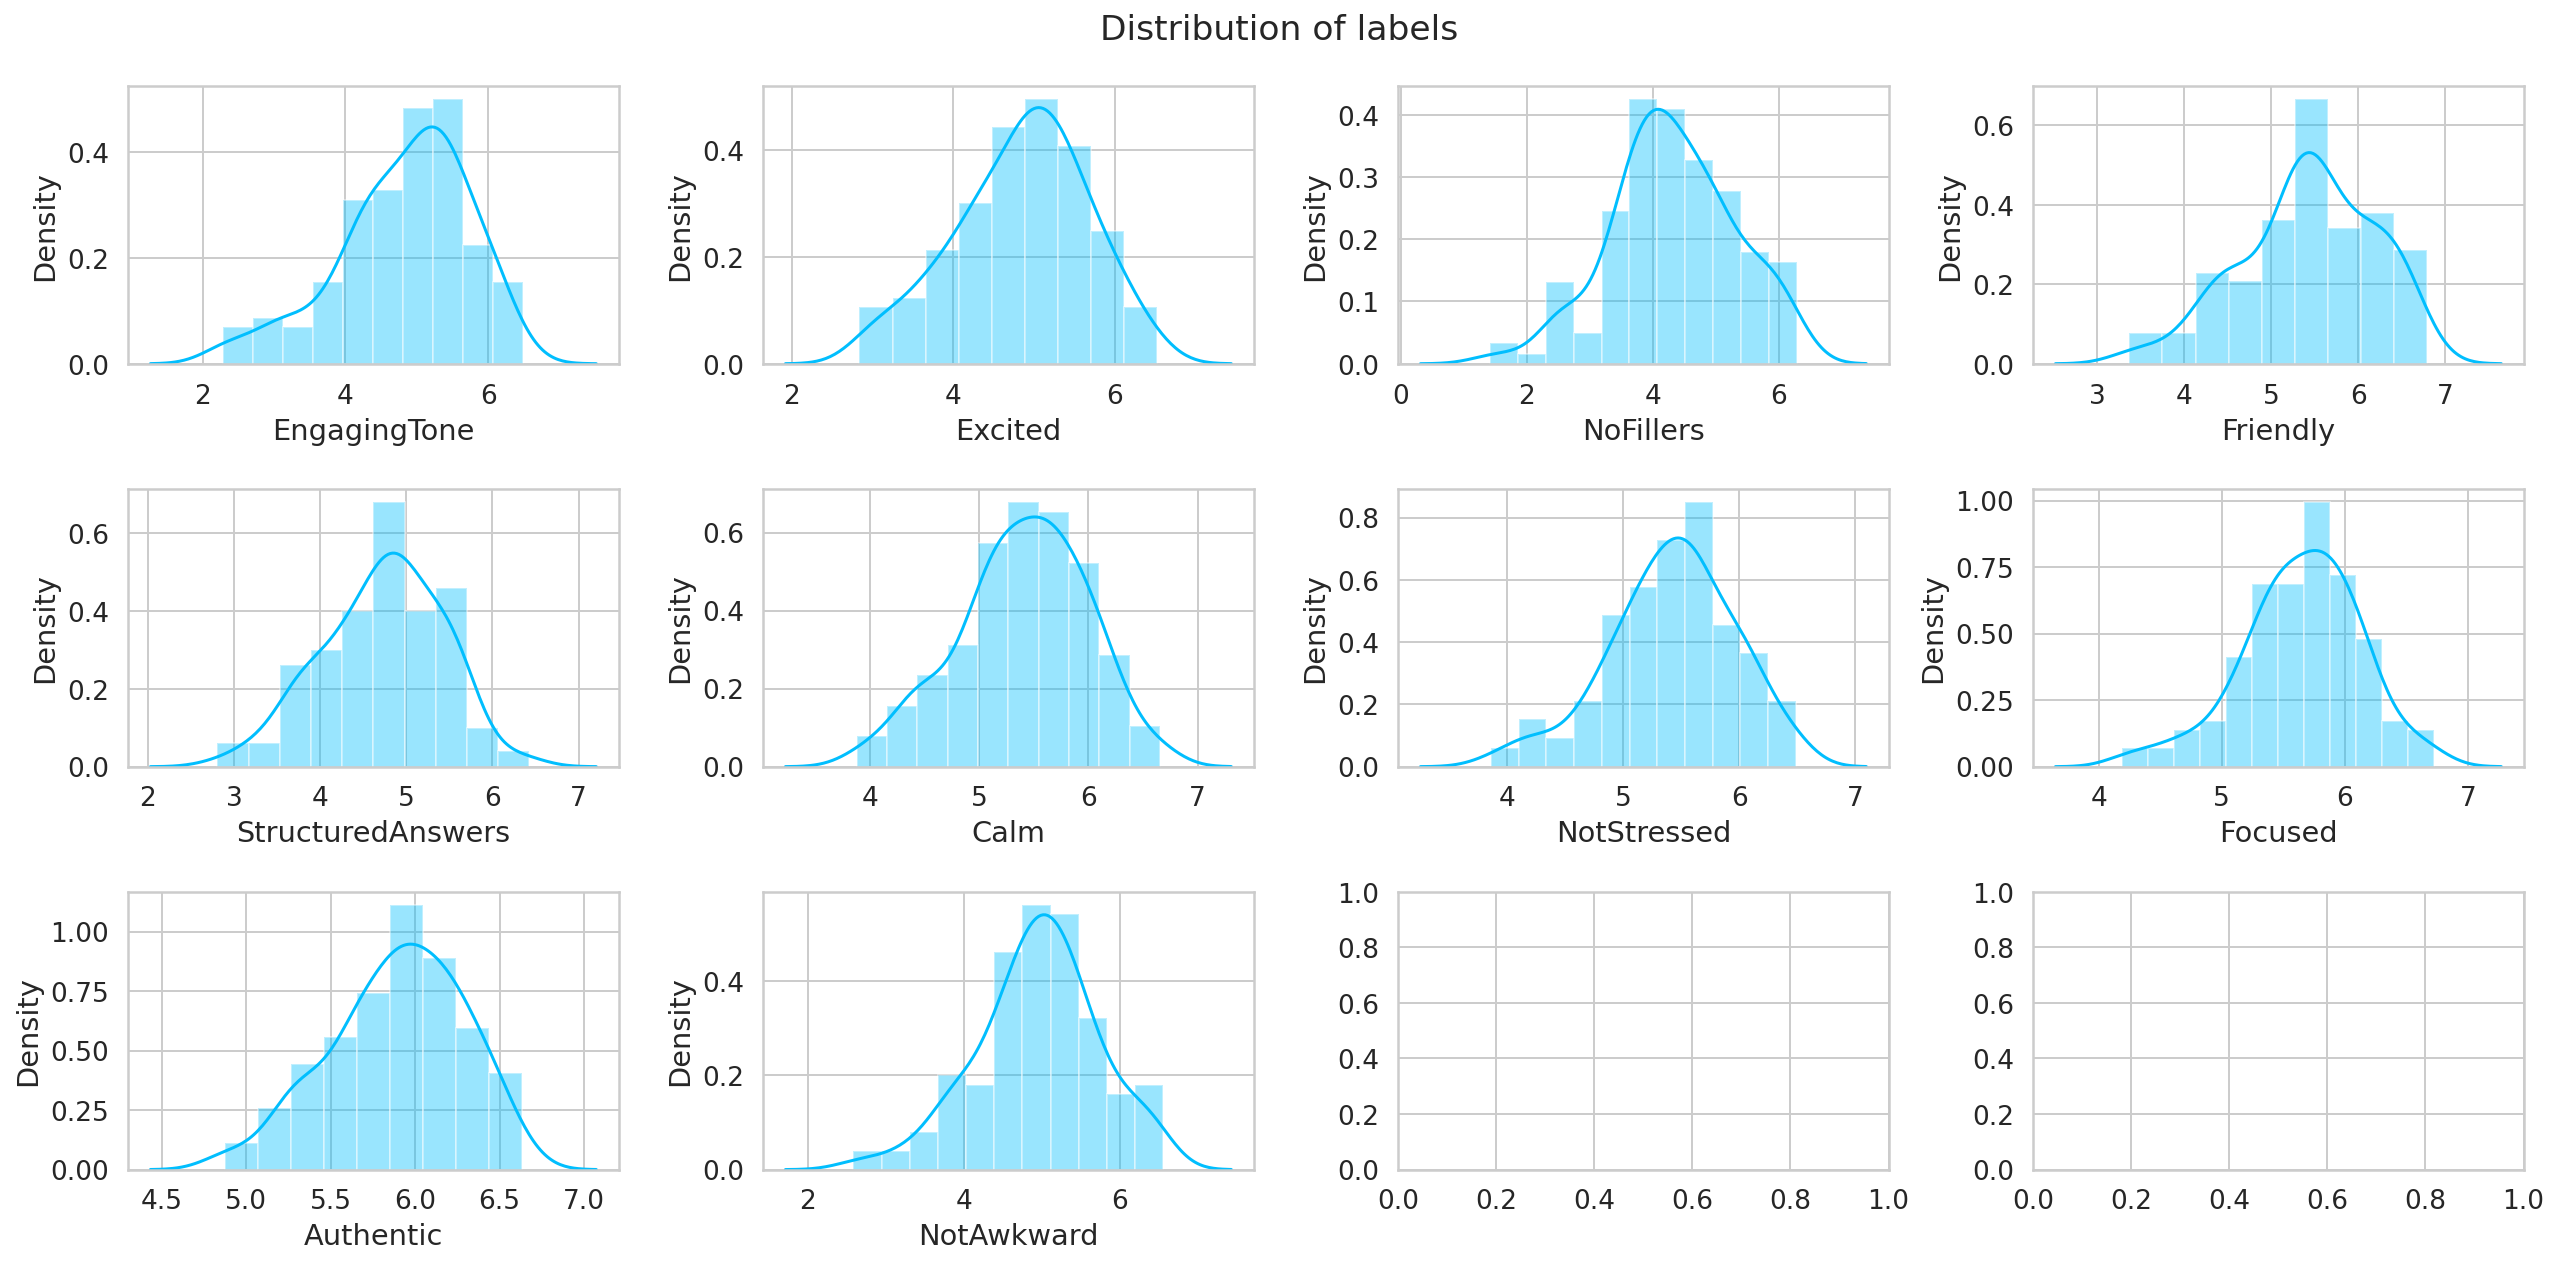

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    fig, axes = plt.subplots(3, 4, figsize=(18, 9))
    fig.suptitle('Distribution of labels')
    # EngagingTone
    sns.distplot(interview_scores['EngagingTone'], ax=axes[0, 0])
    # Excited
    sns.distplot(interview_scores['Excited'], ax=axes[0, 1])
    # NoFillers
    sns.distplot(interview_scores['NoFillers'], ax=axes[0, 2])
    # Friendly
    sns.distplot(interview_scores['Friendly'], ax=axes[0, 3])
    # StructuredAnswers
    sns.distplot(interview_scores['StructuredAnswers'], ax=axes[1, 0])
    # Calm
    sns.distplot(interview_scores['Calm'], ax=axes[1, 1])
    # NotStressed
    sns.distplot(interview_scores['NotStressed'], ax=axes[1, 2])
    # Focused
    sns.distplot(interview_scores['Focused'], ax=axes[1, 3])
    # Authentic
    sns.distplot(interview_scores['Authentic'], ax=axes[2, 0])
    # NotAwkward
    sns.distplot(interview_scores['NotAwkward'], ax=axes[2, 1])
    plt.tight_layout()

## Combine the labels and interviews
- mergeing the dataframes
- drop unnecessary columns
- explod sentence column

In [16]:
interviews_and_labels = interview_scores.merge(interviews_BERT, on='Participant', validate='one_to_one')
interviews_and_labels.drop(['Worker', 'Overall', 'RecommendHiring', 'Colleague', 'Engaged', 'EyeContact', 'Smiled', \
                            'EyeContact', 'Smiled', 'SpeakingRate', 'Paused', 'Total', 'tokenize', 'token_ids' \
                           ], axis=1, inplace=True)
interviews_and_labels.head()

,Participant,Excited,NoFillers,Friendly,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,text_remove_interview_signs,tokenize_sentence_level
0,p1,5.043890,3.771665,5.254784,5.147909,4.891580,5.351075,5.350760,5.845226,5.610513,5.477534,Im pretty good. ok uhm so have you looked at ...,"[ Im pretty good., ok uhm so have you looked a..."
1,p3,5.601586,3.332458,6.500329,5.621231,3.912199,4.476537,5.521215,5.549829,6.014960,4.923550,Good. You?m well. Thanks for coming. Yeah sor...,"[ Good., You?m well., Thanks for coming., Yeah..."
2,p4,4.261343,3.111445,5.369884,4.392736,4.688379,5.065190,5.566084,5.324136,5.658364,4.452909,Pretty good. Uhh so Im a junior uhh studying ...,"[ Pretty good., Uhh so Im a junior uhh studyin..."
3,p5,4.707062,5.881741,5.649119,4.695523,5.582514,6.130488,5.916373,6.322086,6.020070,5.629838,Myself um Im a junior majoring in computer sc...,[ Myself um Im a junior majoring in computer s...
4,p6,4.648259,3.920329,4.495375,4.261988,4.826245,5.828977,5.824390,5.619420,5.371858,5.295977,Im doing good. How are you?Thank you. Well um...,"[ Im doing good., How are you?Thank you., Well..."


In [17]:
# explod sentences

interviews_and_labels = interviews_and_labels.explode('tokenize_sentence_level')
interviews_and_labels['combine'] = interviews_and_labels[['EngagingTone', 'Excited', 'NoFillers', 'Friendly', 'StructuredAnswers', \
               'Calm', 'NotStressed', 'Focused', 'Authentic', 'NotAwkward']].values.tolist()
interviews_and_labels.head()

,Participant,Excited,NoFillers,Friendly,EngagingTone,StructuredAnswers,Calm,NotStressed,Focused,Authentic,NotAwkward,text_remove_interview_signs,tokenize_sentence_level,combine
0,p1,5.04389,3.771665,5.254784,5.147909,4.89158,5.351075,5.35076,5.845226,5.610513,5.477534,Im pretty good. ok uhm so have you looked at ...,Im pretty good.,"[5.14790937729, 5.04389015411, 3.77166473066, ..."
0,p1,5.04389,3.771665,5.254784,5.147909,4.89158,5.351075,5.35076,5.845226,5.610513,5.477534,Im pretty good. ok uhm so have you looked at ...,ok uhm so have you looked at my resume or shou...,"[5.14790937729, 5.04389015411, 3.77166473066, ..."
0,p1,5.04389,3.771665,5.254784,5.147909,4.89158,5.351075,5.35076,5.845226,5.610513,5.477534,Im pretty good. ok uhm so have you looked at ...,Uhm some of that activities that you do out si...,"[5.14790937729, 5.04389015411, 3.77166473066, ..."
0,p1,5.04389,3.771665,5.254784,5.147909,4.89158,5.351075,5.35076,5.845226,5.610513,5.477534,Im pretty good. ok uhm so have you looked at ...,Ok uhm one of the things we have to do for Cam...,"[5.14790937729, 5.04389015411, 3.77166473066, ..."
0,p1,5.04389,3.771665,5.254784,5.147909,4.89158,5.351075,5.35076,5.845226,5.610513,5.477534,Im pretty good. ok uhm so have you looked at ...,Ah so one of the things that I individually sp...,"[5.14790937729, 5.04389015411, 3.77166473066, ..."


## Dataset and dataloader

In [18]:
class InterviewDataset(Dataset):
    def __init__(self, interview_sentence, targets, tokenizer, max_len):
        self.interview_sentence = interview_sentence
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.interview_sentence)

    def __getitem__(self, item):
        interview_sentence = str(self.interview_sentence[item])
        target = self.targets[item]
        encoding = self.tokenizer.encode_plus(
            interview_sentence,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True,
            padding='max_length'
            
        )

        return {
          'interview_sentence': interview_sentence,
          'input_ids': encoding['input_ids'].flatten(),
          'attention_mask': encoding['attention_mask'].flatten(),
          'targets': torch.tensor(target)
        }

In [19]:
df_train, df_test = train_test_split(
  interviews_and_labels,
  test_size=0.2,
  random_state=RANDOM_SEED
)

df_val, df_test = train_test_split(
  df_test,
  test_size=0.5,
  random_state=RANDOM_SEED
)

df_train.shape, df_val.shape, df_test.shape

((4066, 14), (508, 14), (509, 14))

In [20]:
def create_data_loader(df, tokenizer, max_len, batch_size):  
    targets = df['combine'].to_numpy()
    interview_sentence = df['tokenize_sentence_level'].to_numpy()
    ds = InterviewDataset(
        targets = targets,        
        interview_sentence = interview_sentence,
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers = 2
  )

In [21]:
BATCH_SIZE = 4
class_names = ['EngagingTone', 'Excited', 'NoFillers', 'Friendly', 'StructuredAnswers', \
               'Calm', 'NotStressed', 'Focused', 'Authentic', 'NotAwkward']

In [22]:
train_data_loader = create_data_loader(df_train.reset_index(), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val.reset_index(), tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test.reset_index(), tokenizer, MAX_LEN, BATCH_SIZE)

### Example to test dataset and dataloader

In [23]:
data = next(iter(train_data_loader))
data.keys()

dict_keys(['interview_sentence', 'input_ids', 'attention_mask', 'targets'])

In [24]:
print(data['interview_sentence'])
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'])

['I have lots of energy but sometimes its just a bit too much.', 'And um trying to decide what things would be worked on and what wouldnt was a conflict of the team um and I did my best um you know I was an intern um but I did my best to like present the technical issues present my understanding of how long things would take um and try to you know encourage people to take the direction they wanted but in the case that a choice was made that wasnt you know what I wanted uh you know I would go along with it.', 'Hmm Ah...Um I guess again probably using um let me see..ok so I guess again on for the Tech cause its like my major leadership my pretty main extracurricular.', 'Um afterward I talked to a lot of my finance colleagues started taking finance classes went to workshops started networking and I realized you know this is most likely what I want to do.']
torch.Size([4, 75])
torch.Size([4, 75])
tensor([[5.8016, 5.8066, 4.8389, 6.5493, 4.8785, 5.4928, 5.3914, 6.0836, 6.5591,
         5.84

# BERT sentiment analysis

In [25]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Optimize
- drop out
- learning rate is probablly good

10 classes on scale 1 - 7 continous scale

In [26]:
class SentimentClassifier(nn.Module):

    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, 128)
        self.relu1 = nn.ReLU()
        self.out2 = nn.Linear(128, 10)
        

    def forward(self, input_ids, attention_mask):
        output = self.bert(
            input_ids=input_ids,
            attention_mask=attention_mask
            )
        output = self.drop(output.pooler_output)
        output = self.out(output)
        output = self.relu1(output)
        output = self.out2(output)
        return output

In [27]:
model = SentimentClassifier(len(class_names)) # here is something to do
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Test the models output

In [36]:
outputs = []
for i in range(10):
    data = next(iter(train_data_loader))
    outputs.append(model(data['input_ids'], data['attention_mask']).detach().numpy())

In [37]:
outputs[0].shape

(4, 10)

/home/stefan/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

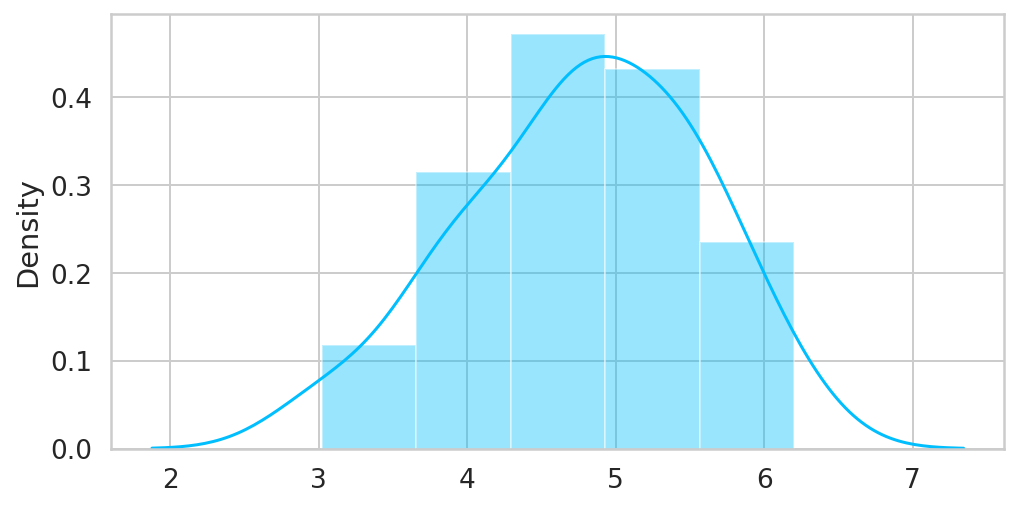

In [38]:
sns.distplot(outputs[0])

In [31]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)
print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([4, 75])
torch.Size([4, 75])


In [32]:
EPOCHS = 7
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

loss_fn = nn.MSELoss().to(device)

## Training

In [33]:
def train_epoch(model, data_loader,loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)
        outputs = model(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        preds = outputs
        loss = loss_fn(preds, targets)
        losses.append(loss.item())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
    
    return np.mean(losses)

In [34]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()
    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            outputs = model(
              input_ids=input_ids,
              attention_mask=attention_mask
            )
            preds = outputs
            loss = loss_fn(preds, targets)
            losses.append(loss.item())
            
    return np.mean(losses)

In [35]:
%%time


history = defaultdict(list)
best_loss = 0

for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}/{EPOCHS}')
    print('-' * 10)
    train_loss = train_epoch(model, train_data_loader, loss_fn, optimizer, device, scheduler, len(df_train))
    print(f'Train loss {train_loss}')
    val_loss = eval_model(model, val_data_loader, loss_fn, device, len(df_val))
    print(f'Val   loss {val_loss}')
    print()
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)

    if val_loss < best_loss:

        torch.save(model.state_dict(), 'best_model_state.bin')
        best_loss = val_loss


Epoch 1/7
----------
Train loss 1.2198965150346446
Val   loss 0.4989207212145873

Epoch 2/7
----------
Train loss 0.5377727247474233
Val   loss 0.4925546691877635

Epoch 3/7
----------
Train loss 0.5221866080748062
Val   loss 0.48961722252406475

Epoch 4/7
----------
Train loss 0.4865334315285922
Val   loss 0.49382572274977765

Epoch 5/7
----------
Train loss 0.4264707505234106
Val   loss 0.48983496357136824

Epoch 6/7
----------
Train loss 0.37716324000290596
Val   loss 0.5044048632693103

Epoch 7/7
----------
Train loss 0.3507663778294035
Val   loss 0.5053097999940707

CPU times: user 7h 8min 18s, sys: 7min 3s, total: 7h 15min 21s
Wall time: 3h 37min 57s
